# Notebook 010: Boston Property Assessments EDA and feature enrichment

This notebooks contains preliminary EDA for Boston property assessments, fiscal years 2013-2019.

Activities completed in this notebook include:

1. Merge all fiscal year records into a single datafile/dataframe
2. Match corresponding latitude and longitude coordinates to each property assessment record
3. Identify missingness of geo-location coordinates (i.e. unmatched remaining assessments)
4. Perform EDA on the dataset
5. Enrich the dataset with additional features (e.g. census-tract indicators, multi-year change rates, etc.)
6. Generate new summary datasets ultimately used for generating engineered features in our final predictive analysis

In [6]:
import urllib
import os
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/property'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim')

readfile_prop_dir = os.path.join(READDIR_ROOT, 'property')
readfile_sam = os.path.join(READDIR_ROOT, 'boston/sam-addresses.csv')
readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_prop_dir, readfile_sam, readfile_zipshapes
    )
)

readfile paths for datasets used in this notebook are:
	../data/raw/property
	../data/raw/boston/sam-addresses.csv
	../data/raw/shapefile/zipcodes/ZIP_Codes.shp


In [8]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)

In [9]:
# read in SAM address data and related shapefiles
df_sam = pd.read_csv(readfile_sam, dtype=str)
gdf_zips = gpd.read_file(readfile_zipshapes)
gdf_boston = gpd.read_file(readfile_cityshape)
gdf_streets = gpd.read_file(readfile_streetshapes)
gdf_tracts = gpd.read_file(readfile_tractshapes)
gdf_hoods = gpd.read_file(readfile_hoodshapes)
gdf_zonesubs = gpd.read_file(readfile_zonesubshapes)

# convert SAM data lat/lon values to floats
df_sam[['X', 'Y']] = df_sam[['X', 'Y']].astype(float)

In [10]:
# check info of SAM dataframe
df_sam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398693 entries, 0 to 398692
Data columns (total 27 columns):
X                       398693 non-null float64
Y                       398693 non-null float64
SAM_ADDRESS_ID          398693 non-null object
RELATIONSHIP_TYPE       398693 non-null object
BUILDING_ID             398693 non-null object
FULL_ADDRESS            398693 non-null object
STREET_NUMBER           398693 non-null object
IS_RANGE                398693 non-null object
RANGE_FROM              26176 non-null object
RANGE_TO                26176 non-null object
UNIT                    270097 non-null object
FULL_STREET_NAME        398693 non-null object
STREET_ID               398693 non-null object
STREET_PREFIX           398693 non-null object
STREET_BODY             398693 non-null object
STREET_SUFFIX_ABBR      394515 non-null object
STREET_FULL_SUFFIX      394515 non-null object
STREET_SUFFIX_DIR       398693 non-null object
STREET_NUMBER_SORT      398693 non-null obj

In [11]:
%%time
#####################################################################
## READ IN ALL PROPERTY ASSESSMENT FILES TO DICT OF DATAFRAME OBJECTS
#####################################################################

# read all property assessment datafiles into dictionary
property_file_list = os.listdir(readfile_prop_dir)
prop_df_dict = {
    '20{0}'.format(filename[2:4]): pd.read_csv(
        os.path.join(readfile_prop_dir, filename),
        dtype=str
    )
    for filename in property_file_list
}
prop_df_dict_keys = sorted(list(prop_df_dict.keys()))

CPU times: user 9.75 s, sys: 363 ms, total: 10.1 s
Wall time: 9.72 s


In [12]:
# inspect df shapes and columns
print('fiscal year\tdataframe shape\n')

for key in prop_df_dict_keys:
    print('{0}\t\t{1}'.format(key, prop_df_dict[key].shape))

fiscal year	dataframe shape

2013		(165608, 54)
2014		(164091, 56)
2015		(168115, 56)
2016		(169199, 77)
2017		(170910, 75)
2018		(172841, 75)
2019		(174668, 75)


In [13]:
# check for differences among dataframe columns year over year
# these will need to be standardized before concatenating dfs
prop_df_columns_dict = {
    year: list(dataframe.columns)
    for year, dataframe in prop_df_dict.items() 
}

column_changes_by_year = {
    year: [
        list(set(prop_df_columns_dict[str(int(year)-1)]).difference(set(prop_df_columns_dict[year]))),
        list(set(prop_df_columns_dict[year]).difference(set(prop_df_columns_dict[str(int(year)-1)])))
    ] for year in prop_df_dict_keys[1:]
}

print('Changes in dataframe column names by fiscal year assessment report:\n')
for key in column_changes_by_year.keys():
    print(key)
    print('  prior year columns removed:\n   {0}'.format(column_changes_by_year[key][0]))
    print('  current year columns added:\n   {0}'.format(column_changes_by_year[key][1]))
    print()

Changes in dataframe column names by fiscal year assessment report:

2014
  prior year columns removed:
   ['MAIL CS', 'U_NUM_PARK', 'MAIL_ADDRESS', 'PID', 'MAIL_ZIPCODE']
  current year columns added:
   ['Owner_MAIL_ZIPCODE', 'Location', 'Parcel_ID', 'full_address', 'Unnamed: 55', 'Owner_MAIL_ADDRESS', 'Owner_MAIL_CS']

2015
  prior year columns removed:
   ['Owner_MAIL_ZIPCODE', 'Parcel_ID', 'Unnamed: 55', 'Owner_MAIL_ADDRESS', 'Owner_MAIL_CS']
  current year columns added:
   ['OWNER_MAIL_CS', 'PID', 'U_NUM_PARK', 'OWNER_MAIL_ZIPCODE', 'OWNER_MAIL_ADDRESS']

2016
  prior year columns removed:
   ['Location', 'U_KIT_TYPE', 'full_address', 'OWNER_MAIL_CS', 'OWNER_MAIL_ZIPCODE', 'OWNER_MAIL_ADDRESS']
  current year columns added:
   ['R_KITCH_STYLE3', 'R_BTH_STYLE', 'U_KITCH_STYLE', 'MAIL_ADDRESS', 'U_BTH_STYLE3', 'R_KITCH_STYLE', 'R_BTH_STYLE3', 'R_INT_CND', 'R_BTH_STYLE2', 'U_INT_CND', 'MAIL_ZIPCODE', 'U_BTH_STYLE2', 'R_VIEW', 'GIS_ID', 'U_BTH_STYLE', 'MAIL CS', 'S_EXT_CND', 'R_INT_

In [14]:
# list of columns to add to dataframes for years in which they are missing
add_columns_list = [
    'LATITUDE', 'LONGITUDE', 
    'Location', 'full_address',
    'MAIL_ADDRESSEE', 'GIS_ID',
    'U_NUM_PARK', 'R_VIEW', 'R_INT_CND',
    'R_BTH_STYLE3', 'U_KITCH_STYLE',
    'U_BTH_STYLE3', 'S_EXT_CND',
    'R_KITCH_STYLE', 'U_BTH_STYLE',
    'R_EXT_CND', 'R_KITCH_STYLE3',
    'R_INT_FIN', 'R_BTH_STYLE',
    'R_BTH_STYLE2', 'R_OVRALL_CND',
    'R_KITCH_STYLE2', 'U_INT_CND',
    'U_VIEW',  'U_INT_FIN', 'U_BTH_STYLE2'
]

# mapping dict to rename column names with variations in spelling
rename_columns_dict = {
    'Parcel_ID': 'PID',
    'OWNER_MAIL_ZIPCODE': 'MAIL_ZIPCODE',
    'Owner_MAIL_ZIPCODE': 'MAIL_ZIPCODE',
    'OWNER_MAIL_ADDRESS': 'MAIL_ADDRESS',
    'Owner_MAIL_ADDRESS': 'MAIL_ADDRESS',
    'OWNER_MAIL_CS': 'MAIL CS',
    'Owner_MAIL_CS': 'MAIL CS',
    'U_KIT_TYPE': 'U_KITCH_TYPE',
}

# list of columns to drop if they exist in df
drop_columns = ['Unnamed: 55']

In [15]:
############################################################
## MODIFY DATAFRAME COLUMNS TO MATCH FOR ALL FISCAL YEAR DFS
############################################################

# add fiscal year row values to each dataframe
for year in prop_df_dict_keys:
    prop_df_dict[year]['fiscal-year'] = year

# add columns to dataframes where they are missing
for year in prop_df_dict_keys:
    for column in add_columns_list:
        if column not in prop_df_dict[year]:
            prop_df_dict[year][column] = np.nan

# remap column names in dataframes where there are variations in naming
for year in prop_df_dict_keys:
    prop_df_dict[year] = prop_df_dict[year].rename(columns=rename_columns_dict)
    
# drop bad columns in drop_columns list if they exist
for year in prop_df_dict_keys:
    prop_df_dict[year] = prop_df_dict[year].drop(columns=drop_columns, errors='ignore')

In [16]:
# check results for matching df widths
print('fiscal year\tdataframe shape\n')

for key in prop_df_dict_keys:
    print('{0}\t\t{1}'.format(key, prop_df_dict[key].shape))

fiscal year	dataframe shape

2013		(165608, 80)
2014		(164091, 80)
2015		(168115, 80)
2016		(169199, 80)
2017		(170910, 80)
2018		(172841, 80)
2019		(174668, 80)


In [17]:
# check year by year column diffs again to ensure not diffs for any years
prop_df_columns_dict_check = {
    year: list(dataframe.columns)
    for year, dataframe in prop_df_dict.items() 
}

column_changes_by_year_check = {
    year: [
        list(set(prop_df_columns_dict_check[str(int(year)-1)]).difference(set(prop_df_columns_dict_check[year]))),
        list(set(prop_df_columns_dict_check[year]).difference(set(prop_df_columns_dict_check[str(int(year)-1)])))
    ] for year in prop_df_dict_keys[1:]
}

print('Changes in dataframe column names by fiscal year assessment report:\n')
for key in column_changes_by_year_check.keys():
    print(key)
    print('  prior year columns removed:\n   {0}'.format(column_changes_by_year_check[key][0]))
    print('  current year columns added:\n   {0}'.format(column_changes_by_year_check[key][1]))
    print()

Changes in dataframe column names by fiscal year assessment report:

2014
  prior year columns removed:
   []
  current year columns added:
   []

2015
  prior year columns removed:
   []
  current year columns added:
   []

2016
  prior year columns removed:
   []
  current year columns added:
   []

2017
  prior year columns removed:
   []
  current year columns added:
   []

2018
  prior year columns removed:
   []
  current year columns added:
   []

2019
  prior year columns removed:
   []
  current year columns added:
   []



In [18]:
########################################################
## CONCATENATE ALL FISCAL YEAR DATAFRAMES INTO SINGLE DF 
########################################################

# The most recent fiscal year is used as the starting reference frame
prop_df = pd.concat(
    [prop_df_dict[year] for year in prop_df_dict_keys[::-1]],
    sort=False,
    ignore_index=True
)

In [19]:
# inspect resulting consolidated dataframe
print(prop_df.info())
prop_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185432 entries, 0 to 1185431
Data columns (total 80 columns):
PID                1185432 non-null object
CM_ID              528555 non-null object
GIS_ID             687305 non-null object
ST_NUM             1185432 non-null object
ST_NAME            1185432 non-null object
ST_NAME_SUF        1182792 non-null object
UNIT_NUM           438126 non-null object
ZIPCODE            1185407 non-null object
PTYPE              1185426 non-null object
LU                 1185431 non-null object
OWN_OCC            1185388 non-null object
OWNER              1185432 non-null object
MAIL_ADDRESSEE     610517 non-null object
MAIL_ADDRESS       1185432 non-null object
MAIL CS            1185432 non-null object
MAIL_ZIPCODE       1185430 non-null object
AV_LAND            1185430 non-null object
AV_BLDG            1185432 non-null object
AV_TOTAL           1185432 non-null object
GROSS_TAX          1185432 non-null object
LAND_SF            1161487 non-

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,fiscal-year,LATITUDE,LONGITUDE,Location,full_address
0,0502550008,502550000,502550000,87,BEACON,ST,2-F,2108,102,CD,...,N,1,N,G,A,2019,NaN,NaN,NaN,NaN
1,0502550010,502550000,502550000,87,BEACON,ST,2-R,2108,102,CD,...,N,1,N,A,A,2019,NaN,NaN,NaN,NaN
2,0502550012,502550000,502550000,87,BEACON,ST,3-F,2108,102,CD,...,N,1,N,A,G,2019,NaN,NaN,NaN,NaN
3,0502550014,502550000,502550000,87,BEACON,ST,3-R,2108,102,CD,...,N,1,S,A,G,2019,NaN,NaN,NaN,NaN
4,0502550016,502550000,502550000,87,BEACON,ST,4,2108,102,CD,...,C,2,N,E,G,2019,NaN,NaN,NaN,NaN


In [20]:
# unpack 'Location' column coordinates to lat/lon columns and fill blanks
prop_df['LATITUDE'] = prop_df['LATITUDE'].fillna(
    prop_df['Location'].copy().str.split('(').str.get(1).str.split('|').str.get(0)
)
prop_df['LONGITUDE'] = prop_df['LONGITUDE'].fillna(
    prop_df['Location'].copy().str.split('|').str.get(1).str.split(')').str.get(0)
)

In [21]:
# check PID values to see unwanted characters
prop_df['PID'].value_counts().sort_index()[:6]

0100001000     3
0100001000_    4
0100002000     3
0100002000_    4
0100003000     3
0100003000_    4
Name: PID, dtype: int64

In [22]:
# remove all non-numeric characters from PID values
prop_df['PID'] = prop_df['PID'].str.replace(r'[^0-9]', '')

# generate a match key for all PIDs with available lats/lons
PID_coord_match_key = prop_df.groupby('PID').agg(
    {
        'LATITUDE': 'first',
        'LONGITUDE': 'first'
    }
)

# convert lat/lon from string to floats
PID_coord_match_key = PID_coord_match_key.astype(float)

# drop zero values
PID_coord_match_key = PID_coord_match_key.replace(0, np.nan)

# store match rate
PID_matchrate = 100 - sum(PID_coord_match_key['LATITUDE'].isnull()) / len(PID_coord_match_key) * 100

# print results to determine how many PIDs still need lat/lon matching
print(
    'Of the {0:,} unique PIDs contained in the {1:,} row consolidated '\
    'property assessment, the following number of PIDs have NO associated '\
    'lat/long coordinates:\n\n\t{2:,}\t{3:.2f}%'.format(
        len(PID_coord_match_key),
        len(prop_df),
        sum(PID_coord_match_key['LATITUDE'].isnull()),
        100 - PID_matchrate
    )
)

Of the 174,167 unique PIDs contained in the 1,185,432 row consolidated property assessment, the following number of PIDs have NO associated lat/long coordinates:

	17,541	10.07%


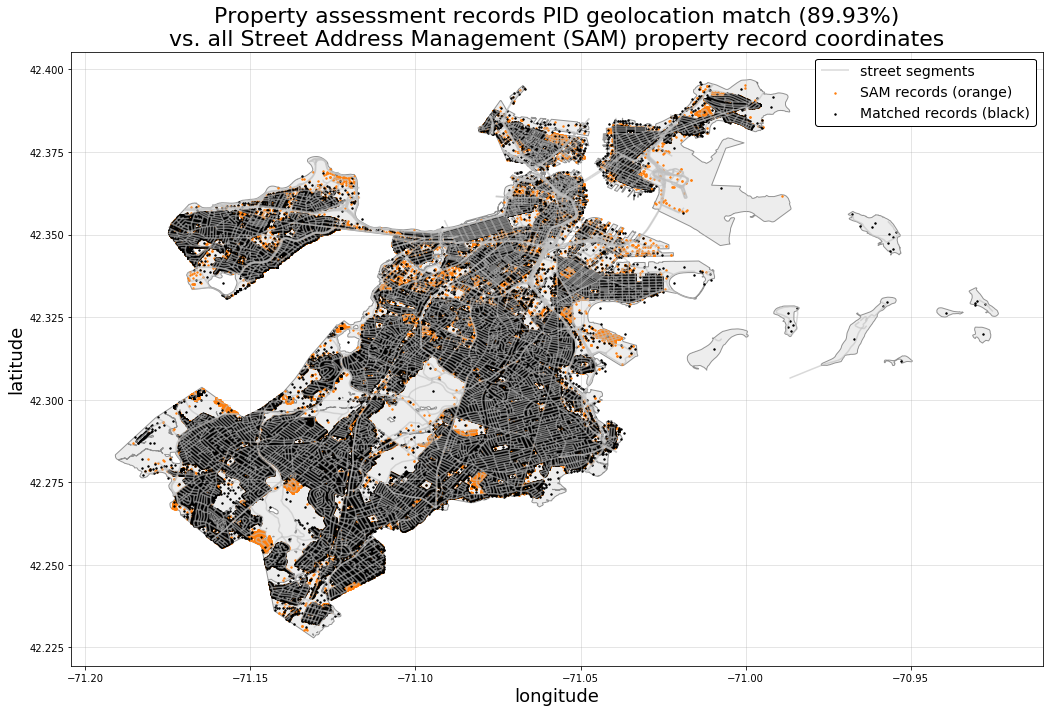

CPU times: user 6.1 s, sys: 83.8 ms, total: 6.18 s
Wall time: 6.2 s


In [23]:
%%time

# Plot PID coordinates from consolidated property dataset over top
# of SAM addresses master list to identify what areas are missing and
# potential sources of bias in our data

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title(
    'Property assessment records PID geolocation match ({0:.2f}%)\n'\
    'vs. all Street Address Management (SAM) property record coordinates'\
    ''.format(PID_matchrate),
    fontsize=22
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, color='tab:orange', s=2, label='SAM records (orange)')
plt.scatter(
    PID_coord_match_key['LONGITUDE'].dropna(), PID_coord_match_key['LATITUDE'].dropna(),
    alpha=1, color='k', s=2, label='Matched records (black)')
plt.xlabel('longitude', fontsize=18)
plt.ylabel('latitude', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
plt.show();

In [24]:
##########################################
## MATCH PID LAT/LONS BY PID ALL FOR YEARS
##########################################
pid_lat_map = dict(zip(PID_coord_match_key.index, PID_coord_match_key['LATITUDE'].values))
pid_lon_map = dict(zip(PID_coord_match_key.index, PID_coord_match_key['LONGITUDE'].values))

prop_df['LATITUDE'] = prop_df['PID'].copy().map(pid_lat_map)
prop_df['LONGITUDE'] = prop_df['PID'].copy().map(pid_lon_map)

In [25]:
# Summarize total property records and lat/lon match rate by year
print(
    'For each fiscal year, there are:\n\nyear\tproperty records\tunmatched '\
    'records\tmatch rate'
)
for year in prop_df_dict_keys:
    print(
        '{0}\t{1:,}\t\t\t{2:,}\t\t\t{3:.2f}%'.format(
            year,
            len(prop_df[prop_df['fiscal-year']==year]),
            sum(prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()),
            100 - sum(
                prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()
            ) / len(prop_df[prop_df['fiscal-year']==year]) * 100 
        )
    )

For each fiscal year, there are:

year	property records	unmatched records	match rate
2013	165,608			6,697			95.96%
2014	164,091			7,209			95.61%
2015	168,115			9,365			94.43%
2016	169,199			10,474			93.81%
2017	170,910			12,477			92.70%
2018	172,841			14,914			91.37%
2019	174,668			16,882			90.33%


## Attempt to match remaining property record locations using SAM data

Now that most property records have been match to lat/lon coordinates, we will attempt to match the remaining using the data available in the SAM records file.

In [26]:
%%time

# clean/normalize match value column data in prop df to ensure consistent matching
prop_df['ST_NAME_SUF'] = prop_df['ST_NAME_SUF'].fillna('').str.strip()
prop_df['ZIPCODE'] = prop_df['ZIPCODE'].fillna('').str.strip().str.replace(r'[^0-9]', '')
prop_df['ZIPCODE'] = ('00000' + prop_df['ZIPCODE']).str[-5:]

# create property match address in all lowercase
prop_df['addr_lower'] = (
    prop_df['ST_NUM'].fillna('').str.strip() + ' ' + \
    prop_df['ST_NAME'].fillna('').str.strip() + ' ' + \
    prop_df['ST_NAME_SUF'].fillna('').str.strip()
).str.strip().str.lower()

# create property street zip match in all lowers
prop_df['st_zip_lower'] = (
    prop_df['ST_NAME'].fillna('').str.strip() + ' ' + \
    prop_df['ST_NAME_SUF'].fillna('').str.strip() + ' ' + \
    prop_df['ZIPCODE'].fillna('').str.strip()
).str.strip().str.lower()

# create property record indicator
prop_df['is_prop'] = 1

# clean/normalize match value column data in SAM df to ensure consistent matching
df_sam['PID'] = df_sam['PARCEL'].copy().str.strip()
# df_sam['GIS_ID'] = df_sam['PARCEL'].copy().str[1:]

# create SAM match address in all lowercase
df_sam['addr_lower'] = (
    df_sam['STREET_NUMBER'].fillna('').str.strip() + ' ' + \
    df_sam['FULL_STREET_NAME'].fillna('').str.strip()
).str.strip().str.lower()

# create SAM street zip match in all lowers
df_sam['st_zip_lower'] = (
    df_sam['FULL_STREET_NAME'].fillna('').str.strip()  + ' ' + \
    df_sam['ZIP_CODE'].fillna('').str.strip()
).str.strip().str.lower()

# rename SAM lat lon columns for merging with property df
df_sam['LONGITUDE'] = df_sam['X']
df_sam['LATITUDE'] = df_sam['Y']

# create SAM record indicator
df_sam['is_sam'] = 1

CPU times: user 4.66 s, sys: 204 ms, total: 4.86 s
Wall time: 4.86 s


In [27]:
# generate matching tables for each SAM to property match method
df_PID_unique = df_sam.groupby('PID').agg(
    {
        'LONGITUDE': 'first',
        'LATITUDE': 'first',
    }
)
df_addr_unique = df_sam.groupby('addr_lower').agg(
    {
        'LONGITUDE': 'first',
        'LATITUDE': 'first',
    }
)
df_st_zip_unique = df_sam.groupby('st_zip_lower').agg(
    {
        'LONGITUDE': 'first',
        'LATITUDE': 'first',
    }
)

In [28]:
# create subset of unmatched property records all years
prop_df_nomatch = prop_df.loc[prop_df['LATITUDE'].isnull()].copy()

print(
    'The starting set of unmatched records prior to attempting other '\
    'match methods contains the following number of records:\n\n\t{0:,}'\
    ''.format(
        len(prop_df_nomatch)
    )
)

The starting set of unmatched records prior to attempting other match methods contains the following number of records:

	78,018


In [29]:
##################################
# map lat and lon based on SAM PID
##################################

sam_pid_lat_map = dict(zip(df_PID_unique.index, df_PID_unique['LATITUDE'].values))
sam_pid_lon_map = dict(zip(df_PID_unique.index, df_PID_unique['LONGITUDE'].values))

prop_df_nomatch['LATITUDE'] = prop_df_nomatch['PID'].copy().map(sam_pid_lat_map)
prop_df_nomatch['LONGITUDE'] = prop_df_nomatch['PID'].copy().map(sam_pid_lon_map)

In [30]:
# create additional subset of unmatched property records all years
prop_df_match = prop_df_nomatch.loc[~prop_df_nomatch['LATITUDE'].isnull()].copy()
prop_df_nomatch = prop_df_nomatch.loc[prop_df_nomatch['LATITUDE'].isnull()].copy()

print(
    'New matches: {0:,}\t\t Still unmatched:  {1:,}'.format(
        len(prop_df_match),
        len(prop_df_nomatch),
    )
)

New matches: 83		 Still unmatched:  77,935


In [31]:
#########################################
# map lat and lon based on SAM addr_lower
#########################################

sam_addr_lat_map = dict(zip(df_addr_unique.index, df_addr_unique['LATITUDE'].values))
sam_addr_lon_map = dict(zip(df_addr_unique.index, df_addr_unique['LONGITUDE'].values))

prop_df_nomatch['LATITUDE'] = prop_df_nomatch['addr_lower'].copy().map(sam_addr_lat_map)
prop_df_nomatch['LONGITUDE'] = prop_df_nomatch['addr_lower'].copy().map(sam_addr_lon_map)

In [32]:
# create additional subset of unmatched property records all years
prop_df_match = pd.concat(
    [
        prop_df_match,
        prop_df_nomatch.loc[~prop_df_nomatch['LATITUDE'].isnull()].copy()
    ], sort=False
)
prop_df_nomatch = prop_df_nomatch.loc[prop_df_nomatch['LATITUDE'].isnull()].copy()

print(
    'New matches: {0:,}\t\t Still unmatched:  {1:,}'.format(
        len(prop_df_match),
        len(prop_df_nomatch),
    )
)

New matches: 45,721		 Still unmatched:  32,297


In [33]:
################################################################
# map lat and lon based on SAM st_zip_lower with indicator added
################################################################

# because this match method may generate some unwanted matching results
# these matched records will be tagged

sam_st_zip_lat_map = dict(zip(df_st_zip_unique.index, df_st_zip_unique['LATITUDE'].values))
sam_st_zip_lon_map = dict(zip(df_st_zip_unique.index, df_st_zip_unique['LONGITUDE'].values))
sam_st_zip_match_map = dict(zip(df_st_zip_unique.index, np.ones(len(df_st_zip_unique))))

prop_df_nomatch['st_zip_match'] = prop_df_nomatch['st_zip_lower'].copy().map(sam_st_zip_match_map) 

prop_df_nomatch['LATITUDE'] = prop_df_nomatch['st_zip_lower'].copy().map(sam_st_zip_lat_map)
prop_df_nomatch['LONGITUDE'] = prop_df_nomatch['st_zip_lower'].copy().map(sam_st_zip_lon_map)

In [34]:
# create additional subset of unmatched property records all years
prop_df_match = pd.concat(
    [
        prop_df_match,
        prop_df_nomatch.loc[~prop_df_nomatch['LATITUDE'].isnull()].copy()
    ], sort=False
)
prop_df_nomatch = prop_df_nomatch.loc[prop_df_nomatch['LATITUDE'].isnull()].copy()

print(
    'New matches: {0:,}\t\t Still unmatched:  {1:,}'.format(
        len(prop_df_match),
        len(prop_df_nomatch),
    )
)

New matches: 60,580		 Still unmatched:  17,438


In [35]:
###################################################################
## RECONSTRUCT FULL PROPERTIES DATASET WITH NEWLY MATCHED LOCATIONS
###################################################################

# save original df length for comparison
orig_len = len(prop_df)

# create new version of df with only matches
prop_df = prop_df.loc[~prop_df['LATITUDE'].isnull()].copy()

# save newly subsetted match records len for comparison
new_len = len(prop_df)

# concatenate all dataframes to regain all records with additional matches
prop_df = pd.concat(
    [
        prop_df,
        prop_df_match,
        prop_df_nomatch
    ],
    sort=False,
    ignore_index=True
)

# fill nan records in st_zip_match col
prop_df['st_zip_match'] = prop_df['st_zip_match'].fillna(0).astype(int)

# save final len
final_len = len(prop_df)

In [36]:
# confirm original df len matches final
orig_len==final_len

True

In [37]:
# Summarize total property records and lat/lon match rate by year
# store match rate
matchrate_final = 100 - sum(prop_df['LATITUDE'].isnull()) / len(prop_df) * 100

print(
    'For each fiscal year, there are:\n\nyear\tproperty records\tunmatched '\
    'records\tmatch rate'
)
for year in prop_df_dict_keys:
    print(
        '{0}\t{1:,}\t\t\t{2:,}\t\t\t{3:.2f}%'.format(
            year,
            len(prop_df[prop_df['fiscal-year']==year]),
            sum(prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()),
            100 - sum(
                prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()
            ) / len(prop_df[prop_df['fiscal-year']==year]) * 100 
        )
    )

For each fiscal year, there are:

year	property records	unmatched records	match rate
2013	165,608			1,692			98.98%
2014	164,091			1,795			98.91%
2015	168,115			2,069			98.77%
2016	169,199			2,125			98.74%
2017	170,910			2,900			98.30%
2018	172,841			3,182			98.16%
2019	174,668			3,675			97.90%


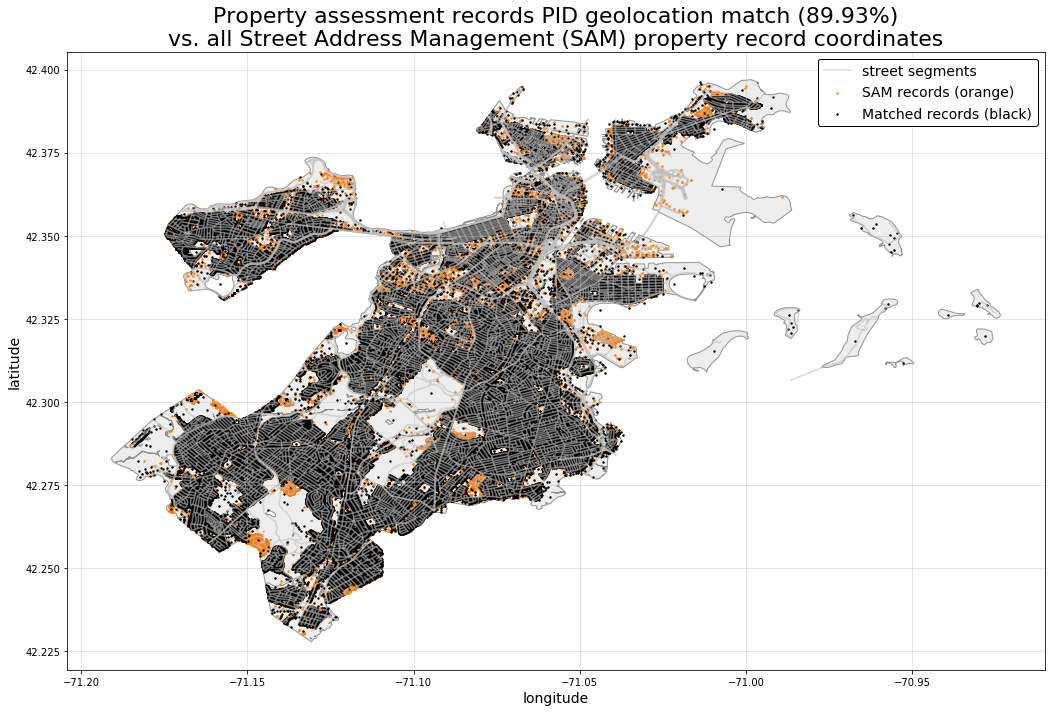

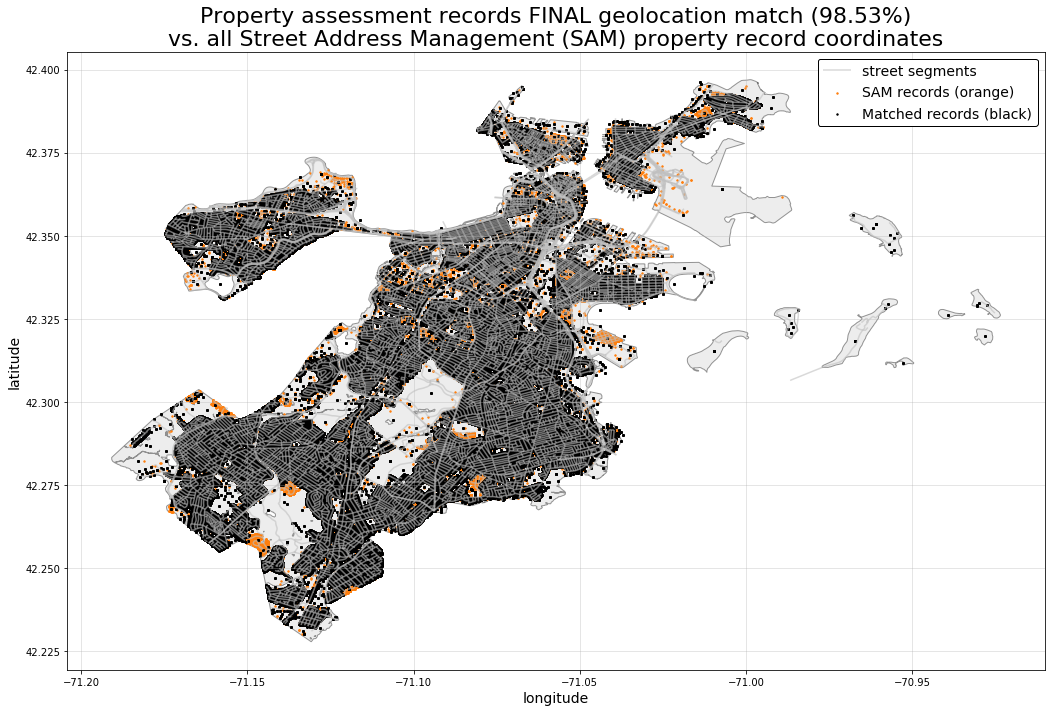

CPU times: user 27.8 s, sys: 694 ms, total: 28.5 s
Wall time: 27.9 s


In [38]:
%%time

# set parameter whether or not to save these two plots
savefig = True

# Plot PID coordinates from consolidated property dataset over top
# of SAM addresses master list to identify what areas are missing and
# potential sources of bias in our data

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title(
    'Property assessment records PID geolocation match ({0:.2f}%)\n'\
    'vs. all Street Address Management (SAM) property record coordinates'\
    ''.format(PID_matchrate),
    fontsize=22
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, color='tab:orange', s=2, label='SAM records (orange)')
plt.scatter(
    PID_coord_match_key['LONGITUDE'].dropna(), PID_coord_match_key['LATITUDE'].dropna(),
    alpha=1, color='k', s=2, label='Matched records (black)')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'match-PID-only.png'))
plt.show();

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title(
    'Property assessment records FINAL geolocation match ({0:.2f}%)\n'\
    'vs. all Street Address Management (SAM) property record coordinates'\
    ''.format(matchrate_final),
    fontsize=22
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, color='tab:orange', s=2, label='SAM records (orange)')
plt.scatter(
    prop_df['LONGITUDE'].dropna(), prop_df['LATITUDE'].dropna(),
    alpha=1, color='k', s=2, label='Matched records (black)')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'match-FINAL.png'))
plt.show();

In [39]:
# plot missing records by zip to identify hot spots

# generate missing record and st_zip_match records to plot as choropleth
missing_records_by_zip = prop_df.loc[prop_df['LATITUDE'].isnull()]['ZIPCODE'].value_counts()
st_zip_match_records_by_zip = prop_df.loc[prop_df['st_zip_match']==1]['ZIPCODE'].value_counts()
missing_records_by_zip.name = 'missing_records'
st_zip_match_records_by_zip.name = 'st_zip_match'


# To lebel zipcodes, find a "representative point" for each polygon geometry
gdf_zips['coords'] = gdf_zips['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf_zips['coords'] = [coords[0] for coords in gdf_zips['coords']]

# make new version of gdf_zips for plotting choropleths
gdf_zips_match = gdf_zips.join(
    missing_records_by_zip, on='ZIP5'
).join(
    st_zip_match_records_by_zip, on='ZIP5'
)

In [43]:
def make_choropleth(gdf, variable, title, cb_label, cmap='Blues',
                    labels=True, savepath=None, citybounds=True):
    """
    plots choropleth
    
    gdf: the geopandas dataframe object containing the polygons and corresponding variable
         of interest
    variable: str, the column name for the variable of interest
    title: str, the title of the plot
    cb_label: str, the label for the colorbar
    cmap: str, the matplotlib predefined colormap colorscheme to use
    labels: boolean, will plot shape label if True. However coordinates for desired
            shapelabels need to stored in gdf in a column titled 'coords'
    savepath: None or str, filepath to which the plot should be saved. If None, the plot
              is not written to disk
    citybounds: boolean, if True, the city boundary for Boston is overlaid on the plot
    """
    # Now to add a colorbar for better interpretability of our choropleth plot

    # set min and max variable values for use in plotting our colorbar
    vmin = gdf[variable].describe()['min']
    vmax = gdf[variable].describe()['max']

    fig, ax = plt.subplots(figsize=(16,10))

    plt.title(
        title,
        fontsize=22
    )

    # NOTE: null values must be dropped from our df (as is shown below).
    #       Otherwise, the choropleth does not provide any gradation in color
    gdf.dropna(subset=[variable]).plot(
        column=variable,
        cmap=cmap,
        linewidth=1,
        ax=ax,
        edgecolor='k'
    )
    
    if citybounds:
        gdf_boston.plot(ax=ax, facecolor="none", edgecolor='k', alpha=0.4)

    # here we use the geopandas dataframe object's built-in iterrows() method
    # to turn zipshape_df into a generator object for iteration
    if labels:
        for idx, row in gdf.iterrows():
            plt.annotate(
                s=row['ZIP5'],
                xy=row['coords'],
                horizontalalignment='center',
                verticalalignment='center',
                weight='bold'
            )

    # here we create a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # ...then we add the colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax, shrink=.8, fraction=0.1)

    # ...and finally we format the colorbar for readability
    cbar.set_label(label='\n{}'.format(cb_label), fontsize=18)
    cbar.ax.tick_params(labelsize=14)

    plt.xlabel('longitude', fontsize=14)
    plt.ylabel('latitude', fontsize=14)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()

    # save figure if savepath is entered
    if savepath:
        plt.savefig(savepath)
    plt.show();


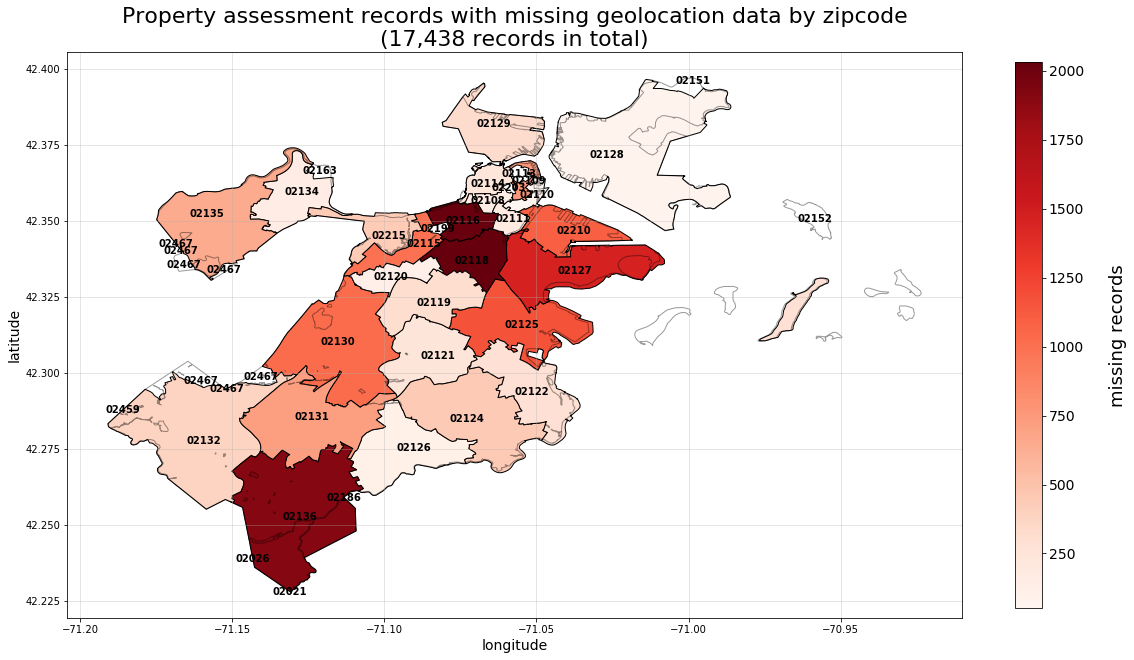

In [41]:
variable = 'missing_records'
cb_label = 'missing records'
title = 'Property assessment records with missing geolocation data by zipcode\n'\
        '({0:,} records in total)'.format(sum(missing_records_by_zip))
savepath = os.path.join(FIGURES_ROOT, 'match-missing-by-zip.png')

make_choropleth(gdf_zips_match, variable, title,
                cb_label, cmap='Reds', labels=True, savepath=savepath)

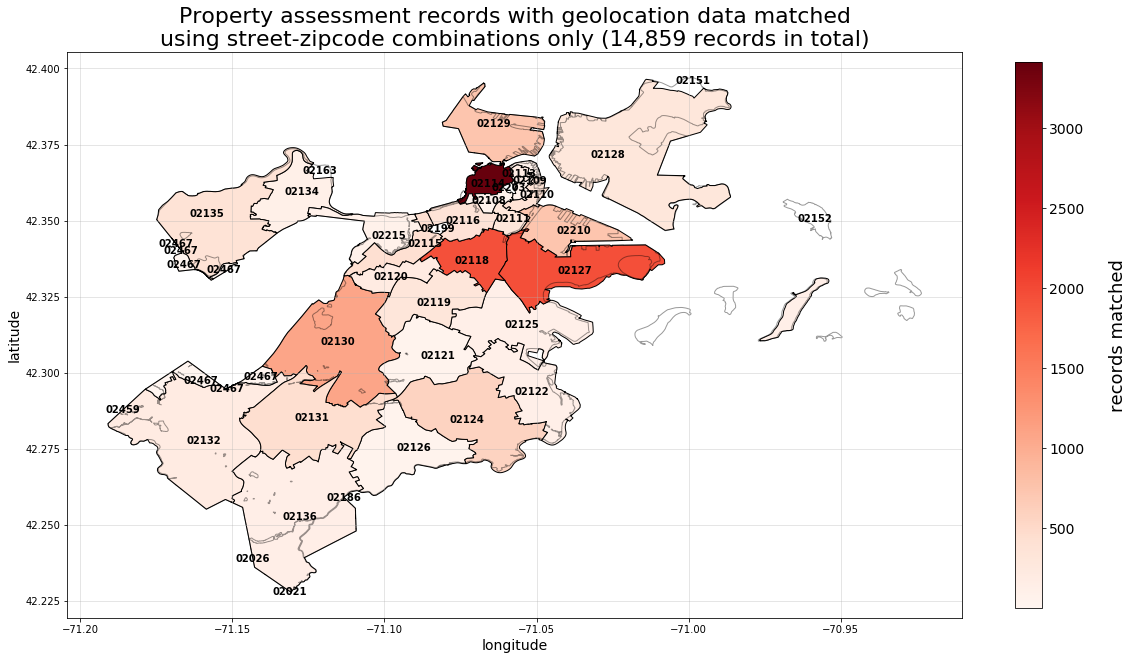

In [42]:
variable = 'st_zip_match'
cb_label = 'records matched'
title = 'Property assessment records with geolocation data matched\nusing '\
        'street-zipcode combinations only ({0:,} records in total)'.format(
    sum(st_zip_match_records_by_zip)
)
savepath = os.path.join(FIGURES_ROOT, 'match-street-zip-only.png')

make_choropleth(gdf_zips_match, variable, title, cb_label,
                cmap='Reds', labels=True, savepath=savepath)

In [44]:
prop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185432 entries, 0 to 1185431
Data columns (total 84 columns):
PID                1185432 non-null object
CM_ID              528555 non-null object
GIS_ID             687305 non-null object
ST_NUM             1185432 non-null object
ST_NAME            1185432 non-null object
ST_NAME_SUF        1185432 non-null object
UNIT_NUM           438126 non-null object
ZIPCODE            1185432 non-null object
PTYPE              1185426 non-null object
LU                 1185431 non-null object
OWN_OCC            1185388 non-null object
OWNER              1185432 non-null object
MAIL_ADDRESSEE     610517 non-null object
MAIL_ADDRESS       1185432 non-null object
MAIL CS            1185432 non-null object
MAIL_ZIPCODE       1185430 non-null object
AV_LAND            1185430 non-null object
AV_BLDG            1185432 non-null object
AV_TOTAL           1185432 non-null object
GROSS_TAX          1185432 non-null object
LAND_SF            1161487 non-

In [ ]:
prop_df.loc[prop_df[]]

In [74]:
lu_drop_list = [
    '102', '144 Beacon St # 2 3 &', '357', '995', '13', np.nan
]
prop_df = prop_df.loc[~prop_df['LU'].isin(lu_drop_list)]

In [99]:
#### SHIFT VALUES LEFT
prop_df.loc[prop_df['AV_LAND'].str.contains('_')].iloc[:,12:32]

,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL CS,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,STRUCTURE_CLASS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS
1146003,NaN,11 WALNUT HILL RD,BROOKLINE MA,NaN,02146_,0,135700,135700,1707,867,1930,1983,867,867,1,NaN,NaN,NaN,NaN,0
1146004,NaN,11 WALNUT HILL RD,BROOKLINE MA,NaN,02146_,0,123200,123200,1549,640,1899,1987,640,640,1,NaN,NaN,NaN,NaN,0


In [90]:
prop_df['YR_BUILT'].value_counts(dropna=False)

0         128654
1900      121209
1920       84744
1910       81606
1905       72090
1899       69897
1890       62104
1930       29417
1999       28283
1925       25857
1880       23077
1950       22830
NaN        20803
1960       16782
2006       16192
1935       15710
1915       14376
1940       12902
1989       11257
1885       10647
1965        9717
2004        9511
1875        9335
2000        9090
1988        8620
1955        8089
1964        7701
2002        6984
1987        6957
1870        6399
           ...  
1785          14
1752          14
1799          10
1798          10
1814           8
1808           7
1792           7
1791           7
1803           7
1700           7
1779           7
1775           7
1823           7
1804           7
1819           7
1807           7
1760           7
1802           7
1710           7
1806           6
2019           3
640            2
324561         2
867            2
773            1
7950           1
1553           1
3802          

In [92]:
prop_df['YR_REMOD'].value_counts(dropna=False)

0       372710
NaN     233895
1999     40541
1985     32969
2005     29512
1980     27537
2004     24435
2006     23036
2002     21647
2003     19783
1986     19079
2000     17862
1984     17427
2001     16237
1983     15292
2007     14846
1987     14744
2008     14696
2009     14466
2012     13571
2010     12966
2011     12435
1982     11771
1997     11507
2013     10831
2015      9474
1989      9472
2014      8730
1981      8727
1996      8491
         ...  
1914        21
1890        21
1927        19
1928        15
1902        14
1951        14
1910        14
1939        11
1923        10
1934         9
1915         8
1921         7
1919         7
1948         7
1941         7
1904         7
1929         7
1937         7
1946         7
1942         7
1878         7
1932         5
995          5
1828         4
1917         4
1893         4
1899         3
1944         3
1500         3
2019         2
Name: YR_REMOD, Length: 110, dtype: int64

In [76]:
prop_df['LU'].value_counts(dropna=False)

CD    425826
R1    214306
R2    121755
R3     98658
CM     64333
E      60310
RL     48333
C      31361
CP     28417
A      20378
RC     19098
R4     17839
CL     14807
CC     12400
EA      4170
I       3409
AH        21
XX         3
Name: LU, dtype: int64

In [77]:
prop_df['PTYPE'].value_counts(dropna=False)[:20]

102    425728
101    214299
104    121755
105     96468
995     64333
132     34659
108     28417
985     18786
111     17840
902     11269
112      8955
13       8146
390      7198
130      6850
125      6657
106      6226
357      5609
986      5577
358      4536
31       4264
Name: PTYPE, dtype: int64

In [78]:
prop_df['OWN_OCC'].value_counts(dropna=False)

N      655273
Y      530107
NaN        44
Name: OWN_OCC, dtype: int64

In [93]:
prop_df[['LIVING_AREA', 'AV_BLDG', 'AV_TOTAL']].astype(float).describe()

,LIVING_AREA,AV_BLDG,AV_TOTAL
count,1.160645e+06,1.185424e+06,1.185424e+06
mean,3.484795e+03,1.371642e+06,1.993435e+06
std,2.540608e+04,1.987173e+07,2.638201e+07
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e+02,1.692000e+05,2.376000e+05
50%,1.290000e+03,2.927000e+05,3.841000e+05
75%,2.434000e+03,4.892000e+05,5.976060e+05
max,2.034730e+06,1.847874e+09,2.111308e+09


In [80]:
prop_df['LIVING_AREA'].astype(float).value_counts(dropna=False)

 0.0         186407
NaN           24779
 1.0           3540
 780.0         1991
 1008.0        1845
 800.0         1814
 1224.0        1740
 1050.0        1728
 600.0         1673
 1075.0        1625
 1306.0        1602
 1440.0        1576
 625.0         1565
 700.0         1560
 960.0         1551
 1000.0        1513
 690.0         1475
 1200.0        1474
 760.0         1463
 864.0         1455
 775.0         1408
 730.0         1380
 1120.0        1359
 1400.0        1358
 1680.0        1357
 750.0         1340
 1800.0        1333
 1920.0        1304
 1080.0        1300
 900.0         1291
              ...  
 9425.0           1
 6129.0           1
 150740.0         1
 17722.0          1
 214000.0         1
 214302.0         1
 6684.0           1
 788441.0         1
 13410.0          1
 6118.0           1
 9525.0           1
 9534.0           1
 5509.0           1
 5531.0           1
 24030.0          1
 13003.0          1
 4612.0           1
 7018.0           1
 6436.0           1


In [95]:
prop_df['R_OVRALL_CND'].value_counts(dropna=False)

NaN    934256
A      205924
G       40457
F        3186
E        1318
P         283
Name: R_OVRALL_CND, dtype: int64

In [96]:
prop_df['R_TOTAL_RMS'].value_counts(dropna=False)

NaN    644361
0      101206
6       59279
7       57381
8       45518
10      40793
12      37549
15      33957
9       31393
11      30840
14      23200
5       21067
18      16993
13      16271
17       9413
16       6520
4        4600
20       1831
21       1343
19        990
3         383
22        148
24        117
23        109
2          68
26         32
25         30
1          15
27          6
09          5
28          3
08          2
05          1
Name: R_TOTAL_RMS, dtype: int64

In [97]:

prop_df['R_BDRMS'].value_counts(dropna=False)

NaN    644359
3      119090
0      101235
4       98693
6       74447
5       55600
2       30843
9       22309
8       15787
7       15211
11       2147
10       1918
1        1662
12       1493
14        207
13        119
06         70
15         61
08         60
09         28
05         25
16         20
04         19
07         10
18          7
03          4
Name: R_BDRMS, dtype: int64

In [103]:
prop_df_2018 = prop_df.loc[prop_df['fiscal-year']=='2018']

In [104]:
prop_df_2018.shape

(172841, 84)

In [105]:
from shapely.geometry import Point

In [118]:
points = [Point(coord[1], coord[0]) for coord in prop_df_2018[['LATITUDE', 'LONGITUDE']].values]
crs = {'init': 'epsg:4326'}
gdf_prop_2018 = gpd.GeoDataFrame(prop_df_2018, crs=crs, geometry=points)

In [109]:
prop_df_2018[['LATITUDE', 'LONGITUDE']].dropna().values

array([[ 42.37938531, -71.03258751],
       [ 42.37941198, -71.03252092],
       [ 42.37943589, -71.03245521],
       ...,
       [ 42.34485867, -71.14798062],
       [ 42.34641267, -71.16683863],
       [ 42.34641267, -71.16683863]])

In [113]:
prop_df_2018['points'] = points

/home/sedelmeyer/Code/cs109a-predicting-crime/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [114]:
prop_df_2018.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,fiscal-year,LATITUDE,LONGITUDE,Location,full_address,addr_lower,st_zip_lower,is_prop,st_zip_match,points
157786,0100001000,NaN,0100001000,104 A 104,PUTNAM,ST,NaN,02128,105,R3,...,2018,42.379385,-71.032588,NaN,NaN,104 a 104 putnam st,putnam st 02128,1,0,POINT (42.3793853108 -71.032587507)
157787,0100002000,NaN,0100002000,197,LEXINGTON,ST,NaN,02128,105,R3,...,2018,42.379412,-71.032521,NaN,NaN,197 lexington st,lexington st 02128,1,0,POINT (42.3794119757 -71.0325209187)
157788,0100003000,NaN,0100003000,199,LEXINGTON,ST,NaN,02128,105,R3,...,2018,42.379436,-71.032455,NaN,NaN,199 lexington st,lexington st 02128,1,0,POINT (42.3794358871 -71.03245521460001)
157789,0100004000,NaN,0100004000,201,LEXINGTON,ST,NaN,02128,105,R3,...,2018,42.379463,-71.032390,NaN,NaN,201 lexington st,lexington st 02128,1,0,POINT (42.3794625221 -71.0323899887)
157790,0100005000,NaN,0100005000,203,LEXINGTON,ST,NaN,02128,104,R2,...,2018,42.379430,-71.032282,NaN,NaN,203 lexington st,lexington st 02128,1,0,POINT (42.3794297699 -71.0322822043)


In [119]:
gpd.sjoin(gdf_prop_2018, gdf_zips, how='left',op="within")

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,is_prop,st_zip_match,points,geometry,index_right,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,coords
157786,0100001000,NaN,0100001000,104 A 104,PUTNAM,ST,NaN,02128,105,R3,...,1,0,POINT (42.3793853108 -71.032587507),POINT (-71.032587507 42.3793853108),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157787,0100002000,NaN,0100002000,197,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794119757 -71.0325209187),POINT (-71.0325209187 42.3794119757),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157788,0100003000,NaN,0100003000,199,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794358871 -71.03245521460001),POINT (-71.03245521460001 42.3794358871),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157789,0100004000,NaN,0100004000,201,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794625221 -71.0323899887),POINT (-71.0323899887 42.3794625221),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157790,0100005000,NaN,0100005000,203,LEXINGTON,ST,NaN,02128,104,R2,...,1,0,POINT (42.3794297699 -71.0322822043),POINT (-71.0322822043 42.3794297699),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157791,0100006000,NaN,0100006000,205 207,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794603622 -71.0322073009),POINT (-71.0322073009 42.3794603622),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157792,0100007000,NaN,0100007000,209 211,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.379490861 -71.03212891610001),POINT (-71.03212891610001 42.379490861),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157793,0100008000,NaN,0100008000,213,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3795184209 -71.03204836259999),POINT (-71.03204836259999 42.3795184209),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157794,0100009000,NaN,0100009000,215,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3795504152 -71.0319650336),POINT (-71.0319650336 42.3795504152),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157795,0100010000,NaN,0100010000,217,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3795820032 -71.0318801072),POINT (-71.0318801072 42.3795820032),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
